In [ ]:
!pip install diffusers==0.25.0 huggingface_hub==0.22.2 transformers accelerate

In [ ]:
!pip install --upgrade diffusers huggingface_hub transformers accelerate

In [ ]:
import os
import copy
import math
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
from diffusers import DDPMPipeline, DDPMScheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import shutil

DRIVE_TEST_SOURCE = "/content/drive/MyDrive/dl_test"
LOCAL_TEST_DIR = "/content/local_test_data"
def copy_data_to_local(source_path, dest_path, data_name="Data"):
    if not os.path.exists(dest_path):
        print(f"Đang copy {data_name} từ Drive sang Local (Tăng tốc độ)...")
        try:
            shutil.copytree(source_path, dest_path)
            print(f"Copy {data_name} hoàn tất!")
        except Exception as e:
            print(f"Lỗi khi copy {data_name}: {e}")
    else:
        print(f"{data_name} đã có sẵn ở Local.")
copy_data_to_local(DRIVE_TEST_SOURCE, LOCAL_TEST_DIR, "Test Set")

TEST_GT_DIR = f"{LOCAL_TEST_DIR}/ground_truth"
TEST_MASKED_DIR = f"{LOCAL_TEST_DIR}/masked_images"
TEST_MASK_DIR = f"{LOCAL_TEST_DIR}/masks"
NUM_TEST_IMAGES = 500

Test Set đã có sẵn ở Local.


### Cấu hình ddpm

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 10
LR = 1e-5
GRAD_CLIP = 1.0
USE_AMP = True
EMA_DECAY = 0.999
NUM_WORKERS = 2

In [ ]:
#1. Dataset
class ImageCompletionDataset(Dataset):
    def __init__(self, root_gt, root_masked, root_mask, size=256):
        self.gt_files = sorted([f for f in os.listdir(root_gt) if f.lower().endswith(('.png','.jpg','.jpeg'))])
        self.masked_files = sorted([f for f in os.listdir(root_masked) if f.lower().endswith(('.png','.jpg','.jpeg'))])
        self.mask_files = sorted([f for f in os.listdir(root_mask) if f.lower().endswith(('.png','.jpg','.jpeg'))])

        assert len(self.gt_files) == len(self.masked_files) == len(self.mask_files), \
            f"Counts mismatch: {len(self.gt_files)}, {len(self.masked_files)}, {len(self.mask_files)}"

        self.root_gt = root_gt
        self.root_masked = root_masked
        self.root_mask = root_mask

        self.img_tf = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
        ])
        self.mask_tf = transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.gt_files)

    def __getitem__(self, idx):
        gt = Image.open(os.path.join(self.root_gt, self.gt_files[idx])).convert("RGB")
        masked = Image.open(os.path.join(self.root_masked, self.masked_files[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.root_mask, self.mask_files[idx])).convert("L")

        gt = self.img_tf(gt)
        masked = self.img_tf(masked)
        mask = self.mask_tf(mask)
        mask = (mask < 0.5).float()

        return {"gt": gt, "masked": masked, "mask": mask}


In [ ]:
test_dataset_eval = ImageCompletionDataset(
    root_gt=TEST_GT_DIR,
    root_masked=TEST_MASKED_DIR,
    root_mask=TEST_MASK_DIR,
    size=256
)
print("Test Dataset size:", len(test_dataset_eval))

Test Dataset size: 500


Đang khởi tạo chế độ: CHECKPOINT
Đang đọc checkpoint từ: /content/drive/MyDrive/ver4_DDPM_checkpoints/epoch_10


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


   -> Phát hiện file .safetensors
Load model thành công từ ổ cứng!
Scheduler ready (DDIM - 50 Steps).
Đang dùng tập TEST chuẩn.

 Bắt đầu test 5 ảnh ngẫu nhiên...

[1/5] Đang test với ảnh index: 479


Img 1:   0%|          | 0/50 [00:00<?, ?it/s]

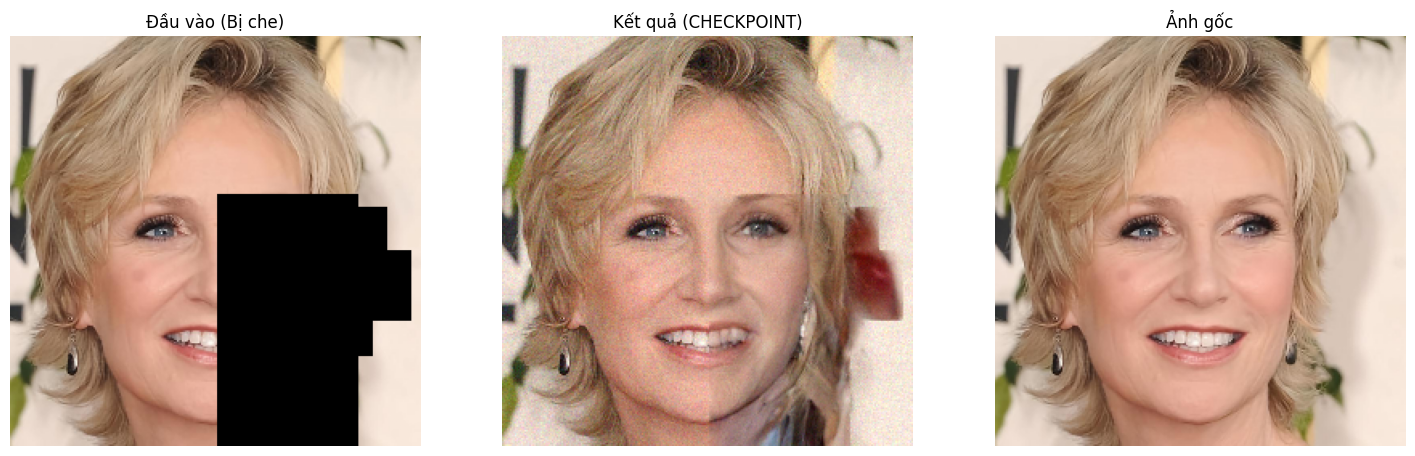


[2/5] Đang test với ảnh index: 28


Img 2:   0%|          | 0/50 [00:00<?, ?it/s]

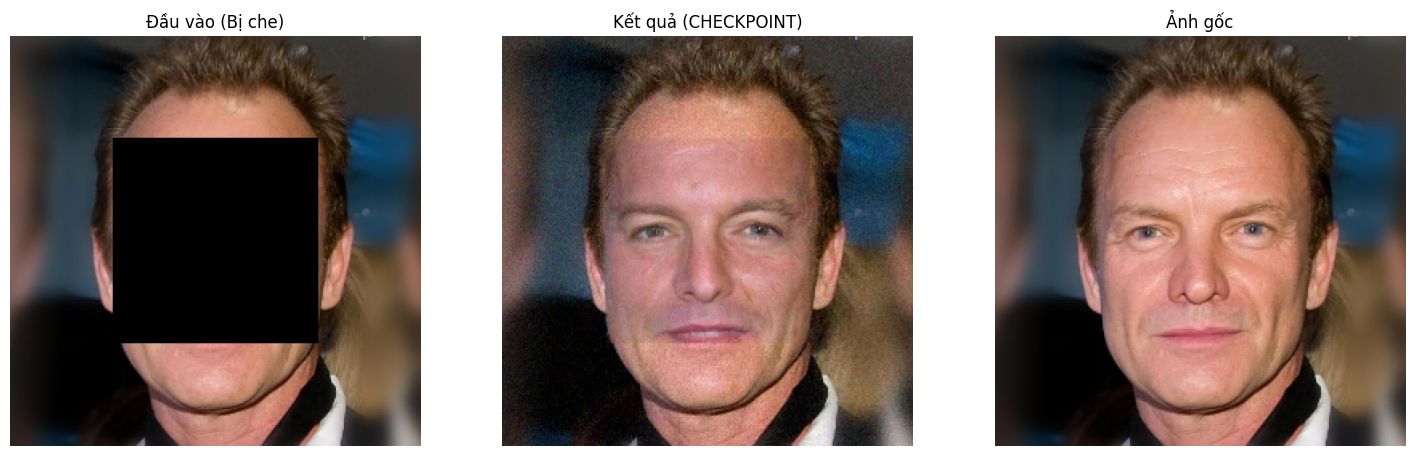


[3/5] Đang test với ảnh index: 179


Img 3:   0%|          | 0/50 [00:00<?, ?it/s]

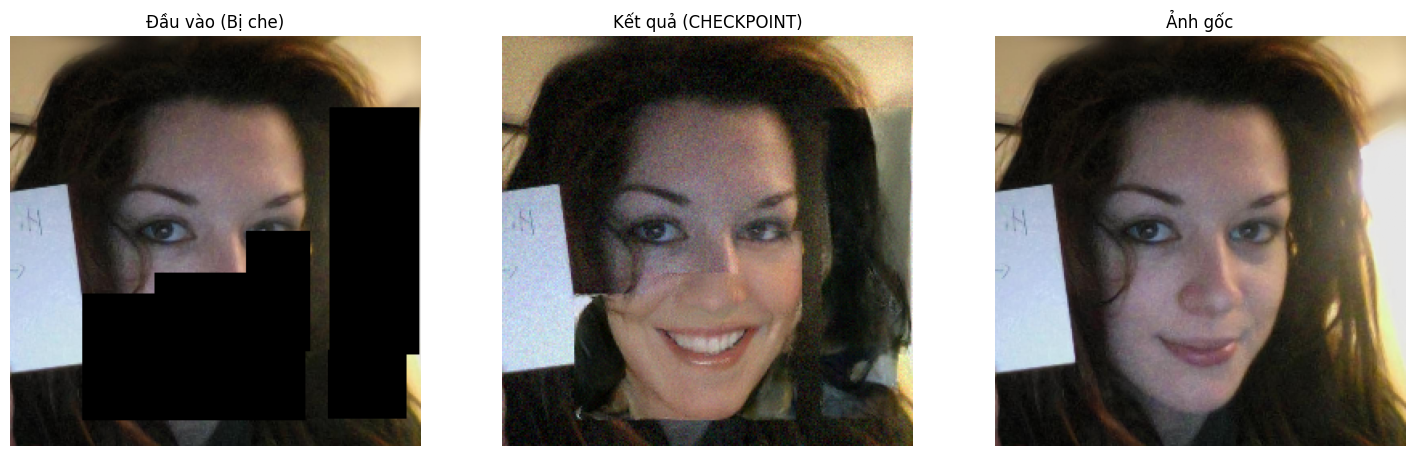


[4/5] Đang test với ảnh index: 100


Img 4:   0%|          | 0/50 [00:00<?, ?it/s]

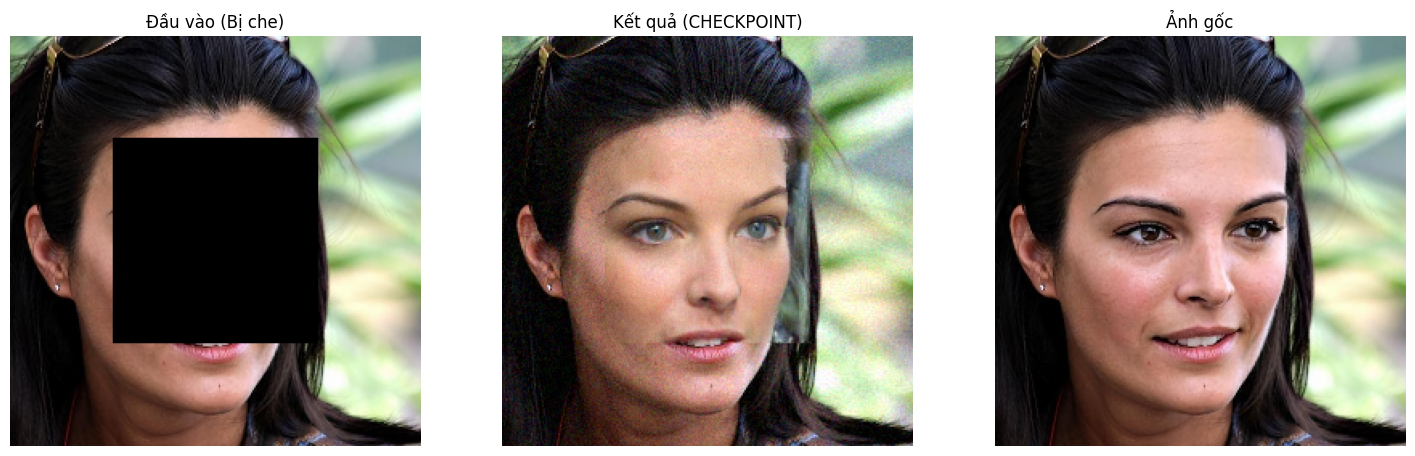


[5/5] Đang test với ảnh index: 23


Img 5:   0%|          | 0/50 [00:00<?, ?it/s]

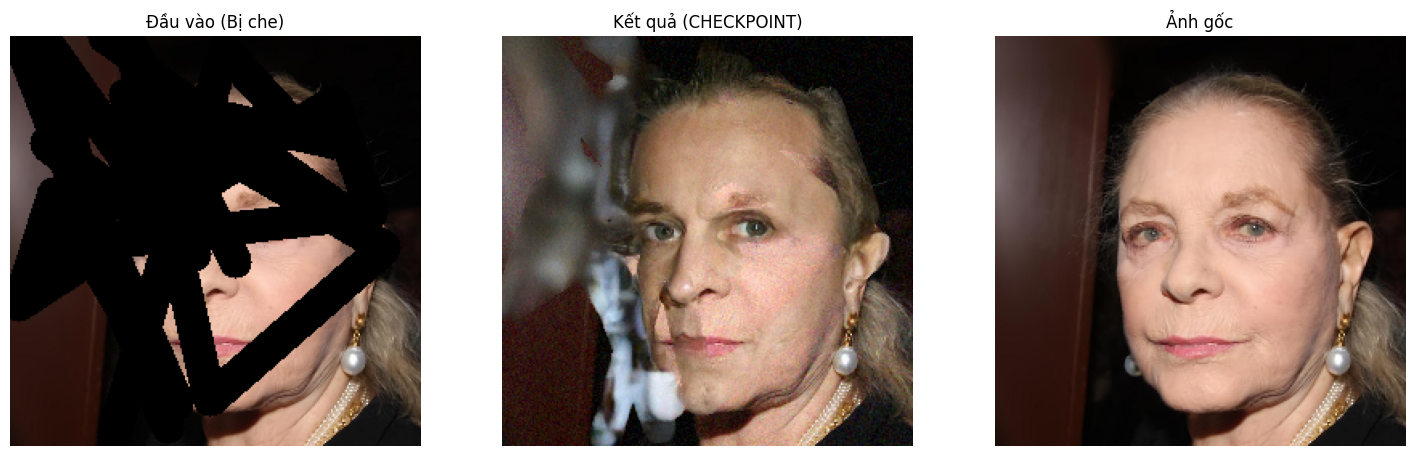

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from diffusers import DDPMPipeline, DDIMScheduler
import torch.nn as nn
from tqdm.auto import tqdm
import shutil
from safetensors.torch import load_file

LOAD_SOURCE = "CHECKPOINT"
CHECKPOINT_PATH = "/content/drive/MyDrive/ver4_DDPM_checkpoints/epoch_10"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_pipeline = None

print(f"Đang khởi tạo chế độ: {LOAD_SOURCE}")

if LOAD_SOURCE == "SESSION":
    if 'pipeline' in globals():
        print("Tìm thấy biến 'pipeline' trong RAM.")
        loaded_pipeline = pipeline
        loaded_pipeline.to(device)
    else:
        raise RuntimeError("Không tìm thấy 'pipeline' trong RAM! Hãy chạy cell Training trước hoặc đổi sang chế độ CHECKPOINT.")

elif LOAD_SOURCE == "CHECKPOINT":
    print(f"Đang đọc checkpoint từ: {CHECKPOINT_PATH}")
    try:
        clean_pipeline = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
        orig_unet = clean_pipeline.unet
        old_conv = None; old_conv_name = None
        for name, module in orig_unet.named_modules():
            if isinstance(module, nn.Conv2d) and module.in_channels == 3:
                old_conv = module; old_conv_name = name; break

        new_first_conv = nn.Conv2d(7, old_conv.out_channels, old_conv.kernel_size,
                                   old_conv.stride, old_conv.padding, old_conv.dilation,
                                   groups=old_conv.groups, bias=(old_conv.bias is not None))
        def set_module_by_name(model, name, new_module):
            parts = name.split("."); obj = model
            for p in parts[:-1]: obj = getattr(obj, p)
            setattr(obj, parts[-1], new_module)

        set_module_by_name(clean_pipeline.unet, old_conv_name, new_first_conv)
        clean_pipeline.unet.in_channels = 7
        clean_pipeline.unet.config["in_channels"] = 7

        safetensors_path = os.path.join(CHECKPOINT_PATH, "unet", "diffusion_pytorch_model.safetensors")
        bin_path = os.path.join(CHECKPOINT_PATH, "unet", "diffusion_pytorch_model.bin")

        state_dict = None
        if os.path.exists(safetensors_path):
            print("   -> Phát hiện file .safetensors")
            state_dict = load_file(safetensors_path)
        elif os.path.exists(bin_path):
            print("   -> Phát hiện file .bin")
            state_dict = torch.load(bin_path, map_location="cpu")
        else:
            raise FileNotFoundError(f"Không tìm thấy file weights trong {CHECKPOINT_PATH}")

        clean_pipeline.unet.load_state_dict(state_dict)
        loaded_pipeline = clean_pipeline
        loaded_pipeline.to(device)
        print("Load model thành công từ ổ cứng")

    except Exception as e:
        print(f"\nLỖI KHI LOAD FILE: {e}")
        loaded_pipeline = None

if loaded_pipeline:
    scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
    print("Scheduler ready (DDIM - 50 Steps).")
else:
    print("Không có model nào được load.")

# 2. INFERENCE
# Kiểm tra Dataset
if 'test_dataset_eval' in globals():
    target_dataset = test_dataset_eval
    print("Đang dùng tập TEST chuẩn.")
else:
    raise ValueError("Chưa có dataset! Hãy chạy cell khởi tạo 'test_dataset_eval' phía trên.")

if loaded_pipeline is not None and target_dataset is not None:
    print(f"\n Bắt đầu test 5 ảnh ngẫu nhiên...")
    SEED = 42
    rng = random.Random(SEED)
    list_img = [479, 28, 179, 100, 23]
    for i in range(5):
        idx = rng.randint(0, len(target_dataset) - 1)
        print(f"\n[{i+1}/5] Đang test với ảnh index: {idx}")

        sample = target_dataset[idx]
        gt = sample["gt"].to(device).unsqueeze(0)
        masked = sample["masked"].to(device).unsqueeze(0)
        mask = sample["mask"].to(device).unsqueeze(0)

        # Chuẩn bị input [-1, 1]
        masked_in = masked * 2.0 - 1.0

        # Quá trình sinh ảnh
        scheduler.set_timesteps(50)
        x_t = torch.randn_like(masked_in)

        loaded_pipeline.unet.eval()

        with torch.no_grad():
            for t in tqdm(scheduler.timesteps, desc=f"Img {i+1}", leave=False):
                model_input = torch.cat([masked_in, mask.to(dtype=x_t.dtype), x_t], dim=1)
                noise_pred = loaded_pipeline.unet(model_input, t).sample
                x_prev = scheduler.step(noise_pred, t, x_t).prev_sample
                if t > 0:
                    noise_t_prev = torch.randn_like(masked_in)
                    gt_noisy = scheduler.add_noise(masked_in, noise_t_prev, torch.tensor([t.item()]).to(device))
                    mask_t = mask.to(dtype=x_prev.dtype)
                    x_t = x_prev * mask_t + gt_noisy * (1 - mask_t)
                else:
                    x_t = x_prev

        result_img = (x_t.clamp(-1, 1) + 1) / 2
        masked_img = masked
        gt_img = gt

        def show_tensor_img(tensor):
            return tensor[0].permute(1, 2, 0).cpu().numpy()

        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(show_tensor_img(masked_img))
        axs[0].set_title("Đầu vào (Bị che)")
        axs[0].axis('off')

        axs[1].imshow(show_tensor_img(result_img))
        axs[1].set_title(f"Kết quả ({LOAD_SOURCE})")
        axs[1].axis('off')

        axs[2].imshow(show_tensor_img(gt_img))
        axs[2].set_title("Ảnh gốc")
        axs[2].axis('off')

        plt.show()

In [ ]:

# TÍNH TOÁN CHỈ SỐ ĐÁNH GIÁ: PSNR, SSIM, LPIPS, FID
import numpy as np
import torch
import lpips
from torchmetrics.image.fid import FrechetInceptionDistance
from skimage.metrics import peak_signal_noise_ratio as psnr_loss
from skimage.metrics import structural_similarity as ssim_loss
from tqdm.auto import tqdm
NUM_TEST_SAMPLES = 500
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Đang tính toán PSNR, SSIM, LPIPS, FID trên {NUM_TEST_SAMPLES} ảnh...")

# LPIPS: Dùng mạng AlexNet
lpips_fn = lpips.LPIPS(net='alex').to(device)
fid_metric = FrechetInceptionDistance(feature=2048, normalize=False).to(device)

psnr_values = []
ssim_values = []
lpips_values = []

target_dataset = test_dataset_eval
indices = list(range(len(target_dataset)))
test_indices = indices[:NUM_TEST_SAMPLES]

loaded_pipeline.unet.eval()
scheduler.set_timesteps(50)

for i, idx in enumerate(tqdm(test_indices, desc="Evaluating")):
    sample = target_dataset[idx]
    gt = sample["gt"].to(device).unsqueeze(0)
    masked = sample["masked"].to(device).unsqueeze(0)
    mask = sample["mask"].to(device).unsqueeze(0)

    masked_in = masked * 2.0 - 1.0
    x_t = torch.randn_like(masked_in)
    with torch.no_grad():
        for t in scheduler.timesteps:
            model_input = torch.cat([masked_in, mask.to(dtype=x_t.dtype), x_t], dim=1)
            noise_pred = loaded_pipeline.unet(model_input, t).sample
            x_prev = scheduler.step(noise_pred, t, x_t).prev_sample

            if t > 0:
                noise_t_prev = torch.randn_like(masked_in)
                gt_noisy = scheduler.add_noise(masked_in, noise_t_prev, torch.tensor([t.item()]).to(device))
                mask_t = mask.to(dtype=x_prev.dtype)
                x_t = x_prev * mask_t + gt_noisy * (1 - mask_t)
            else:
                x_t = x_prev
    pred_tensor = (x_t.clamp(-1, 1) + 1) / 2
    comp_tensor = pred_tensor * mask + gt * (1 - mask)
    comp_tensor_norm = comp_tensor * 2.0 - 1.0
    gt_tensor_norm = gt * 2.0 - 1.0

    with torch.no_grad():
        l_val = lpips_fn(gt_tensor_norm, comp_tensor_norm)
        lpips_values.append(l_val.item())
    comp_uint8 = (comp_tensor * 255).to(torch.uint8)
    gt_uint8 = (gt * 255).to(torch.uint8)

    fid_metric.update(gt_uint8, real=True)
    fid_metric.update(comp_uint8, real=False)
    comp_img_np = comp_tensor[0].permute(1, 2, 0).cpu().numpy()
    comp_img_np = (comp_img_np * 255).astype(np.uint8)

    gt_img_np = sample["gt"].permute(1, 2, 0).cpu().numpy()
    gt_img_np = (gt_img_np * 255).astype(np.uint8)

    p = psnr_loss(gt_img_np, comp_img_np, data_range=255)
    psnr_values.append(p)

    s = ssim_loss(gt_img_np, comp_img_np, data_range=255, channel_axis=2)
    ssim_values.append(s)

avg_psnr = np.mean(psnr_values)
avg_ssim = np.mean(ssim_values)
avg_lpips = np.mean(lpips_values)

print("Đang tổng hợp FID...")
fid_score = fid_metric.compute().item()

print("\n" + "="*40)
print(f"FINAL METRICS (Protocol: Composited Image)")
print("="*40)
print(f"PSNR : {avg_psnr:.4f} dB")
print(f"SSIM : {avg_ssim:.4f}")
print(f"LPIPS : {avg_lpips:.4f}")
print(f"FID : {fid_score:.4f}")
print("="*40)

Đang tính toán PSNR, SSIM, LPIPS, FID trên 500 ảnh...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


Evaluating:   0%|          | 0/500 [00:00<?, ?it/s]

Đang tổng hợp FID...

FINAL METRICS (Protocol: Composited Image)
PSNR : 20.9651 dB
SSIM : 0.8012
LPIPS : 0.1625
FID : 40.4452
